In [1]:
# importing libs
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
import random

Using TensorFlow backend.


In [2]:
# for reproducing reslut

seed_number = 12
tf.set_random_seed(seed_number)
random.seed(seed_number)
np.random.seed(seed_number)

In [3]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16 
k = 2
n_channel = 2
M = 2 ** k
R = k/n_channel
print ('M:',M,'k:',k,'n:',n_channel)

M: 16 k: 4 n: 7


In [4]:
#generating data of size N
N = 8000
label = np.random.randint(M,size=N)

In [5]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [6]:
def BER(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)), axis=-1)  

In [7]:
# checking data shape
data = np.array(data)
print (data.shape)

(8000, 16)


In [8]:
# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

11 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
11 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
11 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [9]:
# defining autoencoder and it's layer
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = BatchNormalization(scale=False, center=False)(encoded1)

# encoded2 = Lambda(lambda x: x / K.sqrt(K.mean(x**2)))(encoded1) #average power constraint

EbNo_train = 5.01187 #  coverted 7 db of EbNo
encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.01)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[BER])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 119       
_________________________________________________________________
batch_normalization_1 (Batch (None, 7)                 14        
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 7)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272 

In [11]:
# for tensor board visualization
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [12]:
# traning auto encoder
autoencoder.fit(data, data, 
                epochs=1000,
                batch_size=100)

0e-04
Epoch 811/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0032 - BER: 1.0938e-04
Epoch 812/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0025 - BER: 9.3750e-05
Epoch 813/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0055 - BER: 1.5625e-04
Epoch 814/1000
8000/8000 [==============================] - 0s 9us/step - loss: 9.7384e-04 - BER: 6.2500e-05
Epoch 815/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0015 - BER: 7.8125e-05
Epoch 816/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0024 - BER: 1.4062e-04
Epoch 817/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0022 - BER: 4.6875e-05
Epoch 818/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0034 - BER: 6.2500e-05
Epoch 819/1000
8000/8000 [==============================] - 0s 9us/step - loss: 0.0018 - BER: 6.2500e-05
Epoch 820/1000
8000/8000 [===================

In [13]:
# saving keras model
from keras.models import load_model
# if you want to save model then remove below comment
# autoencoder.save('autoencoder_v_best.model')

In [14]:
# making encoder from full autoencoder
encoder = Model(input_signal, encoded2)

In [15]:
# making decoder from full autoencoder
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [16]:
# generating data for checking BER
# if you're not using t-sne for visulation than set N to 70,000 for better result 
# for t-sne use less N like N = 1500
N = 100000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [17]:
# checking generated data
temp_test = 6
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])

1.0 1


In [18]:
# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

(16, 1, 7)


In [19]:
 # use this function for ploting constellation for higher dimenson like 7-D for (7,4) autoencoder 
'''
x_emb = encoder.predict(test_data)
noise_std = np.sqrt(1/(2*R*EbNo_train))
noise = noise_std * np.random.randn(N,n_channel)
x_emb = x_emb + noise
from sklearn.manifold import TSNE
X_embedded = TSNE(learning_rate=700, n_components=2,n_iter=35000, random_state=0, perplexity=60).fit_transform(x_emb)
print (X_embedded.shape)
X_embedded = X_embedded / 7
import matplotlib.pyplot as plt
plt.scatter(X_embedded[:,0],X_embedded[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5)) 
plt.grid()
plt.show()
'''

'\nx_emb = encoder.predict(test_data)\nnoise_std = np.sqrt(1/(2*R*EbNo_train))\nnoise = noise_std * np.random.randn(N,n_channel)\nx_emb = x_emb + noise\nfrom sklearn.manifold import TSNE\nX_embedded = TSNE(learning_rate=700, n_components=2,n_iter=35000, random_state=0, perplexity=60).fit_transform(x_emb)\nprint (X_embedded.shape)\nX_embedded = X_embedded / 7\nimport matplotlib.pyplot as plt\nplt.scatter(X_embedded[:,0],X_embedded[:,1])\n#plt.axis((-2.5,2.5,-2.5,2.5)) \nplt.grid()\nplt.show()\n'

In [20]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()

ValueError: cannot reshape array of size 112 into shape (16,2,1)

In [21]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [22]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(frange(-4,10.5,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])
    # use below line for generating matlab like matrix which can be copy and paste for plotting ber graph in matlab
    #print(ber[n], " ",end='')

SNR: -4 BER: 0.50499
SNR: -3.5 BER: 0.47071
SNR: -3.0 BER: 0.43316
SNR: -2.5 BER: 0.39816
SNR: -2.0 BER: 0.35849
SNR: -1.5 BER: 0.31666
SNR: -1.0 BER: 0.27853
SNR: -0.5 BER: 0.24072
SNR: 0.0 BER: 0.20203
SNR: 0.5 BER: 0.1666
SNR: 1.0 BER: 0.13536
SNR: 1.5 BER: 0.10628
SNR: 2.0 BER: 0.08055
SNR: 2.5 BER: 0.06036
SNR: 3.0 BER: 0.04167
SNR: 3.5 BER: 0.02927
SNR: 4.0 BER: 0.01924
SNR: 4.5 BER: 0.0117
SNR: 5.0 BER: 0.0067
SNR: 5.5 BER: 0.0035
SNR: 6.0 BER: 0.00212
SNR: 6.5 BER: 0.00104
SNR: 7.0 BER: 0.00058
SNR: 7.5 BER: 0.00019
SNR: 8.0 BER: 7e-05
SNR: 8.5 BER: 1e-05
SNR: 9.0 BER: 1e-05
SNR: 9.5 BER: 0.0
SNR: 10.0 BER: 0.0


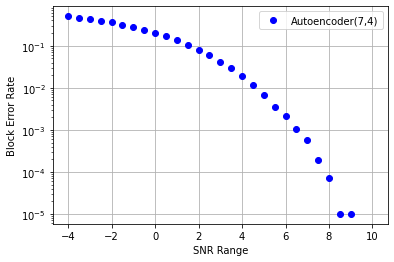

In [23]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder({},{})'.format(n_channel, k))
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)

In [24]:
# for saving figure remove below comment
#plt.savefig('AutoEncoder_2_2_constrained_BER_matplotlib')
plt.show()